<a href="https://colab.research.google.com/github/guidias98/ml_studies/blob/main/%5BHands_on_ML%5D_Chapter_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 - Classification

We will use the MNIST dataset, which is a set of 70k of small images of digits handwritten.

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

Each image has 784 features because it has 28 x 28 pixels, and each feature represents one pixel's intensity, from 0 (white) to 255 (black).

In [3]:
y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classification

Let's simplify the problem and only try to identify one digit - 5. This "5-detector" will be an example of a binary classifier.

In [4]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5.head(5)

,class
0,True
1,False
2,False
3,False
4,False


In [5]:
#training a SGD Classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5.astype(int))

SGDClassifier(random_state=42)

Classes in SGDClassifier context = distinct y values


## Performance measures

### K-fold cross validation

The k-fold cross validation is a procedure used to estimate the skill of a model in new data.

The problem with using just one training set is that it may not give us the necessary confidence that its performance represents the reality - after all, its just one trial. We want to evaluate the model multiple times so we can be more confident.

The "k" in k-fold represents the **number of groups** a given data sample is to be split into.

The steps are as follows:

1. Shuffle the dataset
2. Split the dataset into k groups
3. For each unique group:
4. Take the group as a hold out or test dataset
5. Take the remaining groups as a training dataset
6. Fit a model on the training set and evaluate it on test set
7. Retain the performance score and discard the model
8. Summarize the skill of the model using all of k models

### Stratified K-fold

If we have a dataset with imbalanced classes, when doing a random split of the K-folds we can have one or more folds with few or no examples of the minority class. Therefore, the performance of this folds can be severely harmed since they will only be able to predict the majority class.

In order to prevent that, we can split the dataset in such a way that its class distribution will be maintained for each and every subset/fold. The **stratified k-fold cross-validation** enforce the class distribution in each split of the data to match the distribution in the complete dataset.

### Measuring Accuracy using Cross-Validation

In [6]:
##implementing stratified CV

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5.iloc[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5.iloc[test_index]
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

0.9669
0.91625
0.96785


In [7]:
#anoter way of doing the same thing

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring= 'accuracy')   #for classification tasks, StratifiedKFold is used by default

array([0.95035, 0.96035, 0.9604 ])

The results look great at first hand, but what is the proportion of "5s" and "non-5s"?

In [8]:
y_train_5.value_counts(normalize=True)

,proportion
class,
False,0.90965
True,0.09035


Approximately 91% of registers are "non-5s", so if we made a dumb classifier that always predicts "False", it still would have an accuracy of 91%. That's why accuracy is generally not the preferred performance measure for classifiers, especially when you're dealing with *skewed datasets*.

##

## Confusion Matrix

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each **row** in a confusion matrix represents an **actual class**, while a **column** represents a *predicted class*.

From there we have

*   True Negatives (TN)
*   False Positives (FP)
*   False Negatives (FN)
*   True Positives (TP)



###Precision and Recall

The confusion matrix gives you information, but you may prefer a more concise metric. The first one is called *precision*, which is the accuracy of positive prediction (i.e., the proportion of times the model correctly predicts a 5).

This equals **TP / (TP + FP)**.

If we made just a single positive prediction, and ensure it was correct, we still would have 100% of precision. But what about all of the other positive instances that we left behind? Precision doesn't take them into consideration. Thats why we use it with another metric called *recall*, also called *sensitivity* or *true positive rate (TPR)*, which is the ratio of positive instances detected by the classifier.

recall = TP / (TP + FN)



In [11]:
#Using precision and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(f'Precision: {precision}, recall: {recall}')

Precision: 0.8370879772350012, recall: 0.6511713705958311


It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the *harmonic mean* of precision and recall; the harmonic mean gives much more weight to low values, so F1 score only will be high if both values are high.

In [12]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

F1-score favors classifiers that have similar precision and recall, but that is not always the case. Sometimes we care more about precision, sometimes we are more concerned with recall.

### Precision/Recall trade-off

The way the SGDClassifier makes its classifications is basically computing a score based on a *decision function*. If the score is greater than a threshold, then it assigns the instance to the positive class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores.

In [13]:
some_digit = X_train.iloc[0]

y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [14]:
y_train_5.iloc[0]

np.True_

The SGDClassifier uses a threshold equal to 0, so the instance above would be correctly classified as a positive. If we would raise the thereshold to 8000, it would incorrectly classify it as a negative. So raising the threshold decreases the recall.

How do we decide which threshold to use? We call *cross_val_predict* function to get the scores from all instances in the training sets, but instead of returning predictions, we can ask it to return decision scores.

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method= 'decision_function')

With these scores, we can use the *precision_recall_curve()* function to compute precision and recall for all possible thresholds:

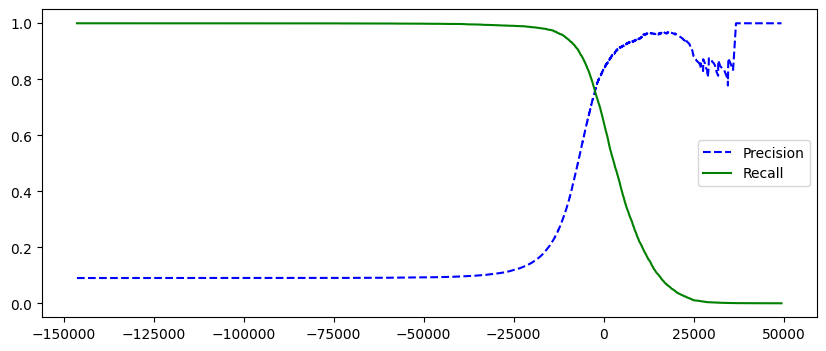

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label= 'Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label= 'Recall')

plt.figure(figsize= (10,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()

## ROC Curve

The ROC (receiving operating characteristic) curve basically plots the *true positive rate* (recall) against the false positive rate (FPR). The FPR ratio is basically 1 - True Negative Rate (TNR); the TNR is also called *specificity*. Hence, the ROC curve basically plots *sensitivity* (recall) versus 1 - *specificity*.



*   Sensitivity: recall
*   Specificity: True Negative Rate

ROC plots *sensitivity* against 1 - *specificity*. That is, it compares how much of the true positive values are captured against how many true negative values we miss.





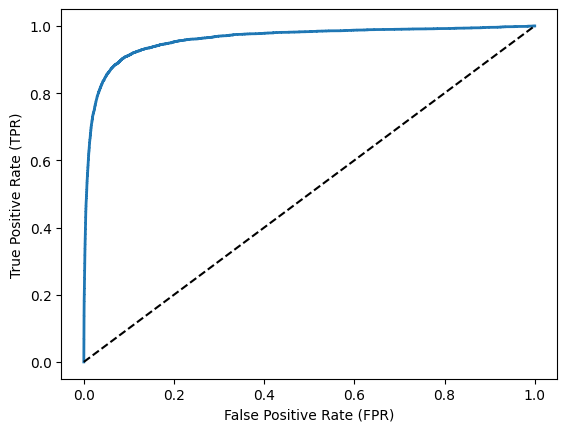

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)  #FPR and TPR for various thresholds

def plot_roc_curve(fpr, tpr, label= None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') #dashed diagonal
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")

plot_roc_curve(fpr, tpr)
plt.show()


One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC = 1, and a purely random classifier will have a ROC AUC = 0.5.

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_train_5, y_scores)
roc_auc

np.float64(0.9604938554008616)

Rule of thumb: use Precision-Recall curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

Let's now train a *Random Forest Classifier* and compare its ROC curve and ROC AUC score to the *SGDClassifier*.

The *Random Forest Classifier* does not have a *decision_function* method. Instead, it has a *predict_proba* method. Scikit-Learn classifiers generally have one or the other, or both.




In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method= 'predict_proba')

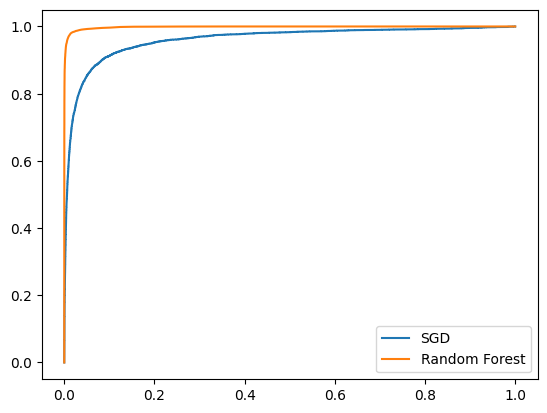

In [23]:
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, label= 'SGD')
plt.plot(fpr_forest, tpr_forest, label= 'Random Forest')
plt.legend(loc= 'lower right')
plt.show()

In [36]:
roc_auc_forest = roc_auc_score(y_train_5, y_scores_forest)
roc_auc_forest

np.float64(0.9983436731328145)

In [33]:
y_pred_forest = (y_scores_forest >= 0.5).astype(int)

precision_forest = precision_score(y_train_5, y_pred_forest)
recall_forest = recall_score(y_train_5, y_pred_forest)

print(f'Precision: {precision_forest}')
print(f'\n Recall: {recall_forest}')

Precision: 0.9897468089558485

 Recall: 0.8725327430363402


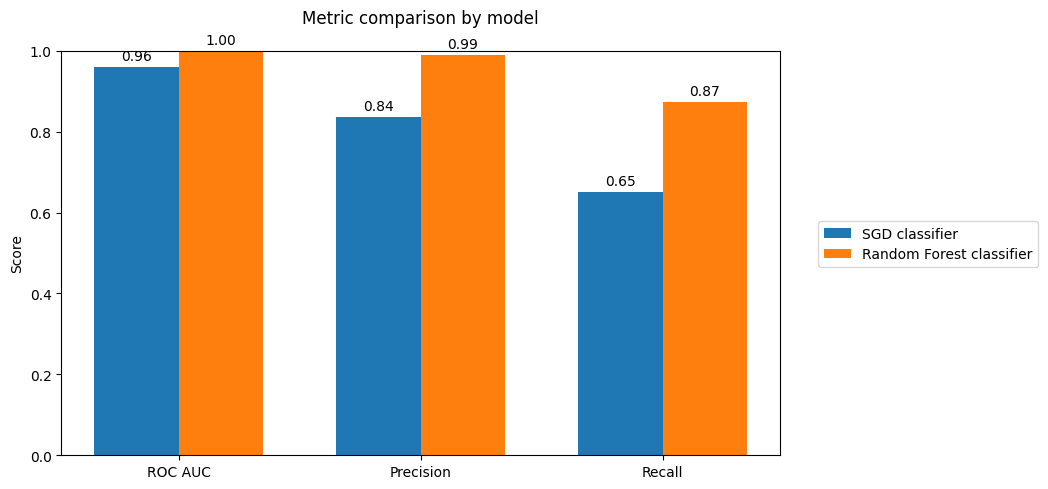

In [55]:
#comparing ROC AUC, precision and recall between SGD and RF models

metrics = ['ROC AUC', 'Precision', 'Recall']

sgd_values = [roc_auc, precision, recall]
forest_values = [roc_auc_forest, precision_forest, recall_forest]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

bars_sgd = ax.bar(x - width/2, sgd_values, width, label='SGD classifier')
bars_rf  = ax.bar(x + width/2, forest_values, width, label='Random Forest classifier')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Metric comparison by model', pad= 20)
ax.set_ylim(0, 1)



# 🔥 labels em cima das barras
ax.bar_label(bars_sgd, fmt='%.2f', padding=3)
ax.bar_label(bars_rf, fmt='%.2f', padding=3)

fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()



The Random Forest classifier clearly outperforms the SGD Classifier in all performance metrics.

## Multiclass Classification